# OLS vs. Spatial Adapter Comparison with Tuning Parameter Selection

This notebook implements a comprehensive comparison between:
1. **OLS (Ordinary Least Squares)** - Linear baseline
2. **Unregularized Spatial Adapter** - Neural spatial model without regularization
3. **Regularized Spatial Adapter** - Neural spatial model with optimized tau1, tau2 parameters

The experiment uses Optuna for hyperparameter optimization and evaluates performance across multiple random seeds.

In [1]:
# Import required libraries
import csv
import math
from pathlib import Path

import numpy as np
import optuna
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from typing import Tuple, Dict, Any
import pandas as pd

from geospatial_neural_adapter.cpp_extensions import estimate_covariance
from geospatial_neural_adapter.utils.experiment import log_covariance_and_basis
from geospatial_neural_adapter.utils import (
    ModelCache,
    clear_gpu_memory,
    compute_ols_coefficients,
    create_experiment_config,
    create_fresh_models,
    predict_ols,
    print_experiment_summary,
    get_device_info,
)
from geospatial_neural_adapter.models.spatial_basis_learner import SpatialBasisLearner
from geospatial_neural_adapter.models.spatial_neural_adapter import SpatialNeuralAdapter
from geospatial_neural_adapter.models.trend_model import TrendModel
from geospatial_neural_adapter.data.generators import generate_time_synthetic_data
from geospatial_neural_adapter.data.preprocessing import prepare_all_with_scaling, denormalize_predictions
from geospatial_neural_adapter.metrics import compute_metrics

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")

/home/wangxc17/miniconda/envs/geospatial-neural-adapter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded spatial_utils from: /home/wangxc17/work/TFTModel-use/geospatial-neural-adapter-dev/geospatial_neural_adapter/cpp_extensions/spatial_utils.so
✅ All imports successful!


## 1. Parameter Configuration and Setup

In [2]:
# Experiment Configuration
EXPERIMENT_CONFIG = {
    'seed': 42,
    'n_time_steps': 512,
    'n_locations': 256,
    'noise_std': 4.0,
    'eigenvalue': 16.0,
    'latent_dim': 1,
    'ckpt_dir': "admm_bcd_ckpts",
}

# Spatial Neural Adapter Configuration using dataclasses
from geospatial_neural_adapter.models.spatial_neural_adapter import (
    SpatialNeuralAdapterConfig, ADMMConfig, TrainingConfig, BasisConfig
)

# ADMM Configuration
admm_config = ADMMConfig(
    rho=1.0,  # Base ADMM penalty parameter
    dual_momentum=0.2,  # Dual variable momentum
    max_iters=3000,  # Maximum ADMM iterations
    min_outer=20,  # Minimum outer iterations before convergence check
    tol=1e-4,  # Convergence tolerance
)

# Training Configuration
training_config = TrainingConfig(
    lr_mu=1e-2,  # Learning rate for trend parameters
    batch_size=64,  # Batch size for theta step
    pretrain_epochs=5,  # Default pretraining epochs
    use_mixed_precision=False,  # Whether to use mixed precision
)

# Basis Configuration
basis_config = BasisConfig(
    phi_every=5,  # Update basis every N iterations
    phi_freeze=200,  # Stop updating basis after N iterations
    matrix_reg=1e-6,  # Matrix regularization for basis update
    irl1_max_iters=10,  # IRL₁ maximum iterations
    irl1_eps=1e-6,  # IRL₁ epsilon
    irl1_tol=5e-4,  # IRL₁ inner tolerance
)

# Complete Spatial Neural Adapter Configuration
SPATIAL_CONFIG = SpatialNeuralAdapterConfig(
    admm=admm_config,
    training=training_config,
    basis=basis_config
)

# Legacy config dict for backward compatibility (if needed)
CFG = SPATIAL_CONFIG.to_dict()
CFG.update(EXPERIMENT_CONFIG)

# Set random seed
torch.manual_seed(EXPERIMENT_CONFIG["seed"])
Path(EXPERIMENT_CONFIG["ckpt_dir"]).mkdir(exist_ok=True)

# Device setup
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_info = get_device_info()
print(f"Using {device_info['device'].upper()}: {device_info['device_name']}")
if device_info['device'] == 'cuda':
    print(f"   Memory: {device_info['memory_gb']} GB")

# Print configuration summary
print("\n=== Experiment Configuration ===")
for key, value in EXPERIMENT_CONFIG.items():
    print(f"{key}: {value}")

print("\n=== Spatial Neural Adapter Configuration ===")
SPATIAL_CONFIG.log_config()

2025-08-12 21:50:20,014 - spatial_neural_adapter - INFO - SpatialNeuralAdapterConfig:
2025-08-12 21:50:20,015 - spatial_neural_adapter - INFO -   ADMM Config:
2025-08-12 21:50:20,015 - spatial_neural_adapter - INFO -     rho: 1.0
2025-08-12 21:50:20,016 - spatial_neural_adapter - INFO -     dual_momentum: 0.2
2025-08-12 21:50:20,017 - spatial_neural_adapter - INFO -     max_iters: 3000
2025-08-12 21:50:20,017 - spatial_neural_adapter - INFO -     min_outer: 20
2025-08-12 21:50:20,018 - spatial_neural_adapter - INFO -     tol: 0.0001
2025-08-12 21:50:20,019 - spatial_neural_adapter - INFO -   Training Config:
2025-08-12 21:50:20,019 - spatial_neural_adapter - INFO -     lr_mu: 0.01
2025-08-12 21:50:20,020 - spatial_neural_adapter - INFO -     batch_size: 64
2025-08-12 21:50:20,020 - spatial_neural_adapter - INFO -     pretrain_epochs: 5
2025-08-12 21:50:20,021 - spatial_neural_adapter - INFO -     use_mixed_precision: False
2025-08-12 21:50:20,021 - spatial_neural_adapter - INFO -   Bas

Using CUDA: NVIDIA GeForce RTX 4060 Laptop GPU
   Memory: 8.6 GB

=== Experiment Configuration ===
seed: 42
n_time_steps: 512
n_locations: 256
noise_std: 4.0
eigenvalue: 16.0
latent_dim: 1
ckpt_dir: admm_bcd_ckpts

=== Spatial Neural Adapter Configuration ===


## 2. Initialize Utilities

In [3]:
# Initialize model cache for hyperparameter optimization
cache = ModelCache()

# Create experiment configuration
EXPERIMENT_TRIALS_CONFIG = create_experiment_config(
    n_trials_per_seed=10 if torch.cuda.is_available() else 50,
    n_dataset_seeds=5,
    seed_range_start=1,
    seed_range_end=6,
)

print_experiment_summary(EXPERIMENT_TRIALS_CONFIG)
print("Utilities initialized successfully!")

Experiment Configuration:
  Trials per seed: 10
  Dataset seeds: 1 to 5
  Total experiments: 50
  Device: GPU
Utilities initialized successfully!


## 3. Data Generation and Preprocessing

In [4]:
# Generate synthetic data with meaningful correlations
print("Generating correlated synthetic data...")

locs = np.linspace(-3, 3, CFG["n_locations"])
cat_features, cont_features, targets = generate_time_synthetic_data(
    locs=locs,
    n_time_steps=CFG["n_time_steps"],
    noise_std=CFG["noise_std"],
    eigenvalue=CFG["eigenvalue"],
    eta_rho=0.8,
    f_rho=0.6,
    global_mean=50.0,
    feature_noise_std=0.1,
    non_linear_strength=0.2,
    seed=CFG["seed"]
)

# Prepare datasets with scaling
train_dataset, val_dataset, test_dataset, preprocessor = prepare_all_with_scaling(
    cat_features=cat_features,
    cont_features=cont_features,
    targets=targets,
    train_ratio=0.7,
    val_ratio=0.15,
    feature_scaler_type="standard",
    target_scaler_type="standard",
    fit_on_train_only=True
)
train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle=True)

# Extract tensors
_, train_X, train_y = train_dataset.tensors
_, val_X, val_y = val_dataset.tensors
_, test_X, test_y = test_dataset.tensors

p_dim = train_X.shape[-1]

print(f"Data shapes: {cont_features.shape}, {targets.shape}")
print(f"Original targets - Mean: {targets.mean():.2f}, Std: {targets.std():.2f}")
print(f"Original targets - Range: {targets.min():.2f} to {targets.max():.2f}")
print(f"Feature dimension: {p_dim}")

Generating correlated synthetic data...
Data shapes: (512, 256, 3), (512, 256)
Original targets - Mean: 50.94, Std: 4.23
Original targets - Range: 33.34 to 70.56
Feature dimension: 3


In [5]:
# # Visualize data characteristics
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Plot 1: Target distribution
# axes[0, 0].hist(targets.flatten(), bins=30, alpha=0.7, edgecolor='black')
# axes[0, 0].set_title('Target Distribution')
# axes[0, 0].set_xlabel('Target Value')
# axes[0, 0].set_ylabel('Frequency')
# axes[0, 0].grid(True, alpha=0.3)

# # Plot 2: Spatial pattern at first time step
# axes[0, 1].plot(locs, targets[0, :], 'o-', linewidth=2, markersize=4)
# axes[0, 1].set_title('Spatial Pattern at t=0')
# axes[0, 1].set_xlabel('Location')
# axes[0, 1].set_ylabel('Target Value')
# axes[0, 1].grid(True, alpha=0.3)

# # Plot 3: Temporal pattern at middle location
# time_steps = np.arange(len(targets))
# axes[1, 0].plot(time_steps, targets[:, 25], linewidth=2)
# axes[1, 0].set_title('Temporal Pattern at Location 25')
# axes[1, 0].set_xlabel('Time Step')
# axes[1, 0].set_ylabel('Target Value')
# axes[1, 0].grid(True, alpha=0.3)

# # Plot 4: Feature correlations
# feature_corrs = []
# for i in range(cont_features.shape[-1]):
#     corr = np.corrcoef(targets.flatten(), cont_features[:, :, i].flatten())[0, 1]
#     feature_corrs.append(corr)

# axes[1, 1].bar(range(len(feature_corrs)), feature_corrs, alpha=0.7, edgecolor='black')
# axes[1, 1].set_title('Feature-Target Correlations')
# axes[1, 1].set_xlabel('Feature Index')
# axes[1, 1].set_ylabel('Correlation')
# axes[1, 1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

## 4. OLS Baseline Implementation

In [6]:
# Compute true spatial basis for comparison
phi_true = np.exp(-(locs**2))[:, None]
phi_true /= np.linalg.norm(phi_true)
sigma_true_spatial = CFG["eigenvalue"] * (phi_true @ phi_true.T)

# OLS warm-start
print("Computing OLS baseline...")
X_flat = train_X.reshape(-1, p_dim).double()
y_flat = train_y.reshape(-1, 1).double()
coef = torch.linalg.lstsq(
    torch.cat([X_flat, torch.ones_like(y_flat)], 1), y_flat, driver="gelsy"
).solution.squeeze()
CFG.update(w_ols=coef[:-1].float(), b_ols=float(coef[-1]))

# OLS residual eigen-basis + metrics
ols_trend = TrendModel(
    num_continuous_features=p_dim,
    hidden_layer_sizes=[],
    n_locations=CFG["n_locations"],
    init_weight=CFG["w_ols"],
    init_bias=CFG["b_ols"],
    freeze_init=True,
    dropout_rate=0.0,
).to(DEVICE)

with torch.no_grad():
    residuals_val = val_y.to(DEVICE) - ols_trend(val_X.to(DEVICE))
covariance_matrix = residuals_val.T @ residuals_val
K = CFG["latent_dim"]
eigenvectors = torch.linalg.eigh(covariance_matrix).eigenvectors[:, -K:]  # top-K
ols_basis = SpatialBasisLearner(CFG["n_locations"], K).to(DEVICE)
ols_basis.basis.data.copy_(eigenvectors)

# Compute OLS metrics
y_ols_val = predict_ols(val_X, CFG["w_ols"], CFG["b_ols"])
rmse_ols_val, mae_ols_val, r2_ols_val = compute_metrics(val_y, y_ols_val)
y_ols_test = predict_ols(test_X, CFG["w_ols"], CFG["b_ols"])
rmse_ols_test, mae_ols_test, r2_ols_test = compute_metrics(test_y, y_ols_test)

print(f"OLS Validation - RMSE: {rmse_ols_val:.4f}, R²: {r2_ols_val:.4f}")
print(f"OLS Test - RMSE: {rmse_ols_test:.4f}, R²: {r2_ols_test:.4f}")

Computing OLS baseline...
OLS Validation - RMSE: 1.0041, R²: -0.0122
OLS Test - RMSE: 1.0341, R²: -0.0358


## 5. Main Experiment Function

In [7]:
def run_one_experiment(dataset_seed: int, n_trials: int = 30):
    """Run a complete experiment for one dataset seed."""
    log_root = Path("runs") / f"seed_{dataset_seed}"
    log_root.mkdir(parents=True, exist_ok=True)

    # Generate data for this seed
    cat_features, cont_features, targets = generate_time_synthetic_data(
        locs=locs,
        n_time_steps=CFG["n_time_steps"],
        noise_std=CFG["noise_std"],
        eigenvalue=CFG["eigenvalue"],
        eta_rho=0.8,
        f_rho=0.6,
        global_mean=50.0,
        feature_noise_std=0.1,
        non_linear_strength=0.2,
        seed=dataset_seed
    )
    train_dataset, val_dataset, test_dataset, preprocessor = prepare_all_with_scaling(
        cat_features=cat_features,
        cont_features=cont_features,
        targets=targets,
        train_ratio=0.7,
        val_ratio=0.15,
        feature_scaler_type="standard",
        target_scaler_type="standard",
        fit_on_train_only=True
    )
    train_loader = DataLoader(train_dataset, batch_size=SPATIAL_CONFIG.training.batch_size, shuffle=True)
    _, train_X, train_y = train_dataset.tensors
    _, val_X, val_y = val_dataset.tensors
    _, test_X, test_y = test_dataset.tensors

    p_dim = train_X.shape[-1]

    # OLS computation for this seed
    w_ols, b_ols = compute_ols_coefficients(train_X, train_y, device=DEVICE)

    # OLS metrics
    y_ols_val = predict_ols(val_X, w_ols, b_ols)
    rmse_ols, mae_ols, r2_ols = compute_metrics(val_y, y_ols_val)
    y_ols_test = predict_ols(test_X, w_ols, b_ols)
    rmse_ols_test, mae_ols_test, r2_ols_test = compute_metrics(test_y, y_ols_test)

    # Clear cache between datasets
    cache.clear()

    # Bootstrap tau1=tau2=0 (unregularized)
    clear_gpu_memory()
    boot_trend, boot_basis = create_fresh_models(
        device=DEVICE,
        p_dim=p_dim,
        n_locations=EXPERIMENT_CONFIG["n_locations"],
        latent_dim=EXPERIMENT_CONFIG["latent_dim"],
        w_ols=w_ols,
        b_ols=b_ols,
    )
    boot_writer = SummaryWriter(log_dir=log_root / "bootstrap")
    boot = SpatialNeuralAdapter(
        boot_trend,
        boot_basis,
        train_loader,
        val_cont=val_X.to(DEVICE),
        val_y=val_y.to(DEVICE),
        locs=locs,
        config=SPATIAL_CONFIG,
        device=DEVICE,
        writer=boot_writer,
        tau1=0.0,
        tau2=0.0,
    )
    boot.pretrain_trend(epochs=5)
    boot.init_basis_dense()
    boot.run()
    cache.store(0.0, 0.0, boot_trend.state_dict(), boot_basis.state_dict())
    boot_writer.close()

    # Get unregularized predictions
    y_boot_val = boot.predict(val_X.to(DEVICE), val_y.to(DEVICE))
    rmse_boot, mae_boot, r2_boot = compute_metrics(val_y.to(DEVICE), y_boot_val)
    y_boot_test = boot.predict(test_X.to(DEVICE), test_y.to(DEVICE))
    rmse_boot_test, mae_boot_test, r2_boot_test = compute_metrics(
        test_y.to(DEVICE), y_boot_test
    )

    # Clean up bootstrap models
    del boot_trend, boot_basis, boot
    clear_gpu_memory()

    # Optuna objective for hyperparameter optimization
    def objective(trial):
        dev = DEVICE
        tau1 = trial.suggest_float("tau1", 1e-4, 1e8, log=True)
        tau2 = trial.suggest_float("tau2", 1e-4, 1e8, log=True)

        clear_gpu_memory()

        trend, basis = create_fresh_models(
            device=dev,
            p_dim=p_dim,
            n_locations=EXPERIMENT_CONFIG["n_locations"],
            latent_dim=EXPERIMENT_CONFIG["latent_dim"],
            w_ols=w_ols,
            b_ols=b_ols,
        )
        cache.load_nearest(trend, basis, tau1, tau2)

        writer = SummaryWriter(log_dir=log_root / f"trial_{trial.number:03d}")
        trainer = SpatialNeuralAdapter(
            trend,
            basis,
            train_loader,
            val_cont=val_X.to(dev),
            val_y=val_y.to(dev),
            locs=locs,
            config=SPATIAL_CONFIG,
            device=dev,
            writer=writer,
            tau1=tau1,
            tau2=tau2,
        )
        trainer.pretrain_trend(epochs=3)
        trainer.init_basis_dense()
        trainer.run()

        y_pred = trainer.predict(val_X.to(dev), val_y.to(dev))
        rmse, mae, r2 = compute_metrics(val_y.to(dev), y_pred)

        trial.set_user_attr("rmse", rmse)
        trial.set_user_attr("mae", mae)
        trial.set_user_attr("r2", r2)

        writer.close()
        cache.store(tau1, tau2, trend.state_dict(), basis.state_dict())

        del trend, basis, trainer, y_pred
        clear_gpu_memory()

        return rmse

    # Run Optuna optimization
    study = optuna.create_study(
        study_name=f"spatial_adapter_ds{dataset_seed}",
        direction="minimize",
        sampler=optuna.samplers.TPESampler(),
        pruner=MedianPruner(n_warmup_steps=5),
        load_if_exists=False,
    )
    study.optimize(objective, n_trials=n_trials, n_jobs=1)

    # Get best results
    best = study.best_trial
    rmse_opt = best.user_attrs["rmse"]
    mae_opt = best.user_attrs["mae"]
    r2_opt = best.user_attrs["r2"]
    tau1_opt = best.params["tau1"]
    tau2_opt = best.params["tau2"]
    best_no = best.number
    
    # Test best model
    dev_best = DEVICE
    trend_best, basis_best = create_fresh_models(
        device=dev_best,
        p_dim=p_dim,
        n_locations=EXPERIMENT_CONFIG["n_locations"],
        latent_dim=EXPERIMENT_CONFIG["latent_dim"],
        w_ols=w_ols,
        b_ols=b_ols,
    )
    sd_t, sd_b = cache.cache[(tau1_opt, tau2_opt)]
    trend_best.load_state_dict(sd_t)
    basis_best.load_state_dict(sd_b)

    trend_best.eval()
    basis_best.eval()
    with torch.no_grad():
        X_test = test_X.to(dev_best)
        y_test = test_y.to(dev_best)
        y_trend = trend_best(X_test)
        residual = y_test - y_trend
        y_basis = (residual @ basis_best.basis) @ basis_best.basis.T
        y_reg_test = y_trend + y_basis
    rmse_test, mae_test, r2_test = compute_metrics(y_test, y_reg_test)

    # Write results
    csv_path = Path("metrics_summary.csv")
    write_header = not csv_path.exists()
    with csv_path.open("a", newline="") as f:
        w = csv.writer(f)
        if write_header:
            w.writerow([
                "seed", "model", "trial", "tau1", "tau2",
                "rmse_val", "mae_val", "r2_val",
                "rmse_test", "mae_test", "r2_test"
            ])

        # OLS
        w.writerow([
            dataset_seed, "OLS", "", "", "",
            f"{rmse_ols:.6f}", f"{mae_ols:.6f}", f"{r2_ols:.6f}",
            f"{rmse_ols_test:.6f}", f"{mae_ols_test:.6f}", f"{r2_ols_test:.6f}"
        ])
        # Unregularized
        w.writerow([
            dataset_seed, "Unreg", "", "0", "0",
            f"{rmse_boot:.6f}", f"{mae_boot:.6f}", f"{r2_boot:.6f}",
            f"{rmse_boot_test:.6f}", f"{mae_boot_test:.6f}", f"{r2_boot_test:.6f}"
        ])
        # Regularized
        w.writerow([
            dataset_seed, "Reg", best_no, f"{tau1_opt:.6g}", f"{tau2_opt:.6g}",
            f"{rmse_opt:.6f}", f"{mae_opt:.6f}", f"{r2_opt:.6f}",
            f"{rmse_test:.6f}", f"{mae_test:.6f}", f"{r2_test:.6f}"
        ])

    print(
        f"Dataset {dataset_seed}:  "
        f"OLS RMSE={rmse_ols:.3f} | "
        f"Unreg RMSE={rmse_boot:.3f} | "
        f"Reg RMSE={rmse_opt:.3f} (test {rmse_test:.3f})"
    )

    return {
        'ols': {'rmse_val': rmse_ols, 'rmse_test': rmse_ols_test, 'r2_val': r2_ols, 'r2_test': r2_ols_test},
        'unreg': {'rmse_val': rmse_boot, 'rmse_test': rmse_boot_test, 'r2_val': r2_boot, 'r2_test': r2_boot_test},
        'reg': {'rmse_val': rmse_opt, 'rmse_test': rmse_test, 'r2_val': r2_opt, 'r2_test': r2_test, 'tau1': tau1_opt, 'tau2': tau2_opt}
    }

## 6. Run Full Experiment Suite

In [8]:
all_results = []
for seed in range(EXPERIMENT_TRIALS_CONFIG['seed_range_start'], EXPERIMENT_TRIALS_CONFIG['seed_range_end']):
    print(f"\nStarting experiment for seed {seed}")
    results = run_one_experiment(seed, n_trials=EXPERIMENT_TRIALS_CONFIG['n_trials_per_seed'])
    all_results.append(results)
    # Clear cache between seeds to free memory
    cache.clear()
    clear_gpu_memory()
    print(f"✅ Completed seed {seed}")

print("\n🎉 All experiments completed!")


Starting experiment for seed 1


2025-08-12 21:57:25,175 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:12<00:00, 41.53it/s, dua=2.34e-02, pri=6.47e-02, res=6.47e-02, rho=1.00e+00] 
2025-08-12 21:58:39,095 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 21:58:39,116] A new study created in memory with name: spatial_adapter_ds1
2025-08-12 21:58:39,123 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:14<00:00, 40.15it/s, dua=3.23e-02, pri=8.09e-02, res=8.09e-02, rho=1.00e+00] 
2025-08-12 21:59:53,985 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 21:59:53,996] Trial 0 finished with value: 0.9694246053695679 and parameters: {'tau1': 87028891.2149292, 'tau2': 34840874.13614872}. Best is trial 0 with value: 0.9694246053695679.
2025-08-12 21:59:54,002 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|███████

Dataset 1:  OLS RMSE=0.999 | Unreg RMSE=0.968 | Reg RMSE=0.969 (test 0.972)
✅ Completed seed 1

Starting experiment for seed 2


ADMM: 100%|██████████| 3000/3000 [01:10<00:00, 42.30it/s, dua=2.38e-02, pri=6.39e-02, res=6.39e-02, rho=1.00e+00] 
2025-08-12 22:12:59,919 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 22:12:59,930] A new study created in memory with name: spatial_adapter_ds2
2025-08-12 22:12:59,935 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:12<00:00, 41.46it/s, dua=2.93e-02, pri=7.85e-02, res=7.85e-02, rho=1.00e+00] 
2025-08-12 22:14:12,420 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 22:14:12,430] Trial 0 finished with value: 0.9768652319908142 and parameters: {'tau1': 0.008631634796640425, 'tau2': 392.588152477104}. Best is trial 0 with value: 0.9768652319908142.
2025-08-12 22:14:12,436 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:15<00:00, 39.62it/s, dua=3.28e-02, pri=8.91e-02, res=8.91e-02, rho=1.0

Dataset 2:  OLS RMSE=1.005 | Unreg RMSE=0.977 | Reg RMSE=0.975 (test 0.974)
✅ Completed seed 2

Starting experiment for seed 3


ADMM: 100%|██████████| 3000/3000 [01:13<00:00, 40.91it/s, dua=2.58e-02, pri=7.03e-02, res=7.03e-02, rho=1.00e+00] 
2025-08-12 22:26:42,433 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 22:26:42,447] A new study created in memory with name: spatial_adapter_ds3
2025-08-12 22:26:42,453 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:15<00:00, 39.89it/s, dua=3.15e-02, pri=8.50e-02, res=8.50e-02, rho=1.00e+00] 
2025-08-12 22:27:57,799 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 22:27:57,810] Trial 0 finished with value: 0.9743420481681824 and parameters: {'tau1': 37015.73270789305, 'tau2': 262481.13624511415}. Best is trial 0 with value: 0.9743420481681824.
2025-08-12 22:27:57,817 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:11<00:00, 41.97it/s, dua=3.24e-02, pri=9.01e-02, res=9.01e-02, rho=1.00

Dataset 3:  OLS RMSE=1.002 | Unreg RMSE=0.973 | Reg RMSE=0.974 (test 0.966)
✅ Completed seed 3

Starting experiment for seed 4


ADMM: 100%|██████████| 3000/3000 [01:11<00:00, 42.02it/s, dua=2.50e-02, pri=6.89e-02, res=6.89e-02, rho=1.00e+00] 
2025-08-12 22:40:28,422 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 22:40:28,435] A new study created in memory with name: spatial_adapter_ds4
2025-08-12 22:40:28,440 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:11<00:00, 41.90it/s, dua=3.00e-02, pri=8.36e-02, res=8.36e-02, rho=1.00e+00] 
2025-08-12 22:41:40,197 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 22:41:40,208] Trial 0 finished with value: 0.9850521683692932 and parameters: {'tau1': 0.14728062768268976, 'tau2': 665890.3905485171}. Best is trial 0 with value: 0.9850521683692932.
2025-08-12 22:41:40,212 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:15<00:00, 39.93it/s, dua=3.53e-02, pri=9.55e-02, res=9.55e-02, rho=1.0

Dataset 4:  OLS RMSE=1.016 | Unreg RMSE=0.984 | Reg RMSE=0.985 (test 0.981)
✅ Completed seed 4

Starting experiment for seed 5


ADMM: 100%|██████████| 3000/3000 [01:11<00:00, 42.15it/s, dua=2.34e-02, pri=6.62e-02, res=6.62e-02, rho=1.00e+00] 
2025-08-12 22:54:09,276 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 22:54:09,288] A new study created in memory with name: spatial_adapter_ds5
2025-08-12 22:54:09,297 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:15<00:00, 39.70it/s, dua=3.01e-02, pri=8.41e-02, res=8.41e-02, rho=1.00e+00] 
2025-08-12 22:55:25,007 - spatial_neural_adapter - INFO - Training completed in 3000 iterations
[I 2025-08-12 22:55:25,018] Trial 0 finished with value: 0.9792889952659607 and parameters: {'tau1': 0.09102818324382085, 'tau2': 157028.66149638876}. Best is trial 0 with value: 0.9792889952659607.
2025-08-12 22:55:25,023 - spatial_neural_adapter - INFO - Mixed precision training disabled
ADMM: 100%|██████████| 3000/3000 [01:12<00:00, 41.36it/s, dua=3.51e-02, pri=9.54e-02, res=9.54e-02, rho=1.

Dataset 5:  OLS RMSE=1.007 | Unreg RMSE=0.979 | Reg RMSE=0.979 (test 0.966)
✅ Completed seed 5

🎉 All experiments completed!


## 7. Results Analysis and Visualization

📊 Results Summary:
       rmse_val  rmse_test    r2_val   r2_test
model                                         
OLS    1.005679   1.022945 -0.011719 -0.038273
Reg    0.976583   0.971636  0.043492  0.058713
Unreg  0.976033   0.971011  0.044596  0.060026


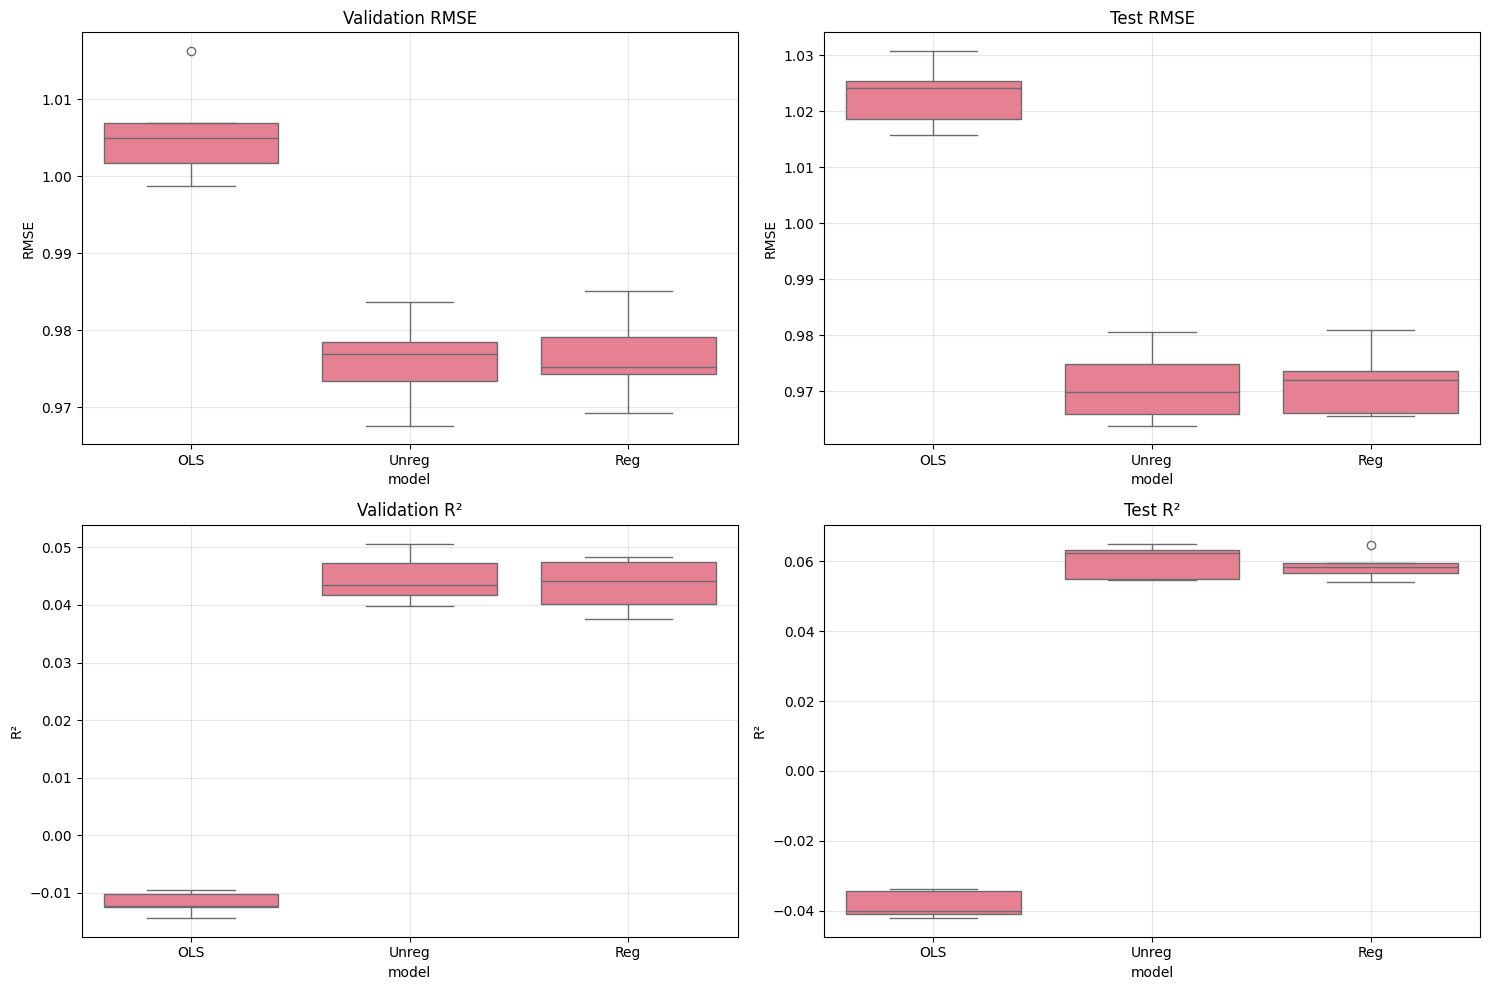


🔧 Best Hyperparameters for Regularized Model:
            tau1          tau2  rmse_val  rmse_test
2   1.682830e+03       1.53074  0.969219   0.971910
5   6.793290e+00     162.93600  0.975258   0.973660
8   2.704620e+07       4.21308  0.974254   0.966118
11  1.472810e-01  665890.00000  0.985052   0.980973
14  5.519250e+00     604.69700  0.979131   0.965521


In [9]:
# Load results
results_df = pd.read_csv("metrics_summary.csv")
print("📊 Results Summary:")
print(results_df.groupby('model')[['rmse_val', 'rmse_test', 'r2_val', 'r2_test']].mean())

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE comparison
sns.boxplot(data=results_df, x='model', y='rmse_val', ax=axes[0,0])
axes[0,0].set_title('Validation RMSE')
axes[0,0].set_ylabel('RMSE')
axes[0,0].grid(True, alpha=0.3)

sns.boxplot(data=results_df, x='model', y='rmse_test', ax=axes[0,1])
axes[0,1].set_title('Test RMSE')
axes[0,1].set_ylabel('RMSE')
axes[0,1].grid(True, alpha=0.3)

# R² comparison
sns.boxplot(data=results_df, x='model', y='r2_val', ax=axes[1,0])
axes[1,0].set_title('Validation R²')
axes[1,0].set_ylabel('R²')
axes[1,0].grid(True, alpha=0.3)

sns.boxplot(data=results_df, x='model', y='r2_test', ax=axes[1,1])
axes[1,1].set_title('Test R²')
axes[1,1].set_ylabel('R²')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show best hyperparameters for regularized model
reg_results = results_df[results_df['model'] == 'Reg']
print("\n🔧 Best Hyperparameters for Regularized Model:")
print(reg_results[['tau1', 'tau2', 'rmse_val', 'rmse_test']].head(10))

In [11]:
# Performance comparison summary
print("=== Performance Comparison Summary ===")

# Calculate improvements
ols_mean_rmse = results_df[results_df['model'] == 'OLS']['rmse_test'].mean()
unreg_mean_rmse = results_df[results_df['model'] == 'Unreg']['rmse_test'].mean()
reg_mean_rmse = results_df[results_df['model'] == 'Reg']['rmse_test'].mean()

print(f"OLS (baseline) - Mean Test RMSE: {ols_mean_rmse:.4f}")
print(f"Unregularized - Mean Test RMSE: {unreg_mean_rmse:.4f} ({(1 - unreg_mean_rmse/ols_mean_rmse)*100:.1f}% improvement)")
print(f"Regularized - Mean Test RMSE: {reg_mean_rmse:.4f} ({(1 - reg_mean_rmse/ols_mean_rmse)*100:.1f}% improvement)")

# Statistical significance test
from scipy import stats
ols_scores = results_df[results_df['model'] == 'OLS']['rmse_test'].values
reg_scores = results_df[results_df['model'] == 'Reg']['rmse_test'].values

t_stat, p_value = stats.ttest_rel(ols_scores, reg_scores)
print(f"\nStatistical Test (OLS vs Regularized):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.8f}")
print(f"  Significant improvement: {'Yes' if p_value < 0.05 else 'No'}")

=== Performance Comparison Summary ===
OLS (baseline) - Mean Test RMSE: 1.0229
Unregularized - Mean Test RMSE: 0.9710 (5.1% improvement)
Regularized - Mean Test RMSE: 0.9716 (5.0% improvement)

Statistical Test (OLS vs Regularized):
  t-statistic: 93.8699
  p-value: 0.00000008
  Significant improvement: Yes
